# Kuairec dataset
Source: https://kuairec.com/

In [1]:
# Change this line to read from desired file

In [2]:
import sys

In [3]:
sys.path.append("/home/gerardoduran/documents/low-rank-last-layer-inference/experiments/")

In [4]:
cd "~/documents/KuaiRec 2.0"

/home/gerardoduran/documents/KuaiRec 2.0


/home/gerardoduran/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [7]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [8]:
%config InlineBackend.figure_format = "retina"

In [9]:
video_stats = pd.read_csv("./data/item_daily_features.csv")

# Shift features by one day
new_dates = pd.to_datetime(video_stats["date"].astype(str)) - pd.Timedelta(days=1)
video_stats["date"] = new_dates.apply(lambda x: int(x.strftime("%Y%m%d")))

In [10]:
target_cols = [
    "video_id", "date", "like_cnt", "share_cnt", "play_cnt", "comment_cnt",
    "complete_play_cnt", "follow_cnt", "reply_comment_cnt", "download_cnt",
]
video_stats[target_cols]

,video_id,date,like_cnt,share_cnt,play_cnt,comment_cnt,complete_play_cnt,follow_cnt,reply_comment_cnt,download_cnt
0,0,20200704,573,2,10141,11,5657,284,3,8
1,0,20200705,302,1,7321,7,4162,201,1,2
2,0,20200706,205,1,4757,4,2734,131,1,2
3,0,20200707,297,2,5172,4,2950,179,2,3
4,0,20200708,307,0,5392,5,3058,186,5,2
...,...,...,...,...,...,...,...,...,...,...
343336,10723,20200904,24,0,214,0,117,0,0,0
343337,10724,20200904,264,1,965,29,535,8,0,1
343338,10725,20200904,851,3,15487,36,8149,12,2,5
343339,10726,20200904,44,1,7859,0,5480,2,0,2


In [12]:
cols_merge = ["video_id", "date"]
small_matrix = pd.read_csv("data/small_matrix.csv").dropna()
small_matrix = small_matrix.merge(video_stats[target_cols], on=cols_merge)
small_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,like_cnt,share_cnt,play_cnt,comment_cnt,complete_play_cnt,follow_cnt,reply_comment_cnt,download_cnt
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,3485,72,578125,626,406287,290,265,33
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,9478,67,481643,168,332326,355,45,31
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,24073,807,1230980,462,796486,1174,33,308
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,77044,500,1353520,1341,781144,5121,337,371
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,6404,23,475632,339,262597,416,53,14


<Axes: xlabel='watch_ratio', ylabel='Count'>

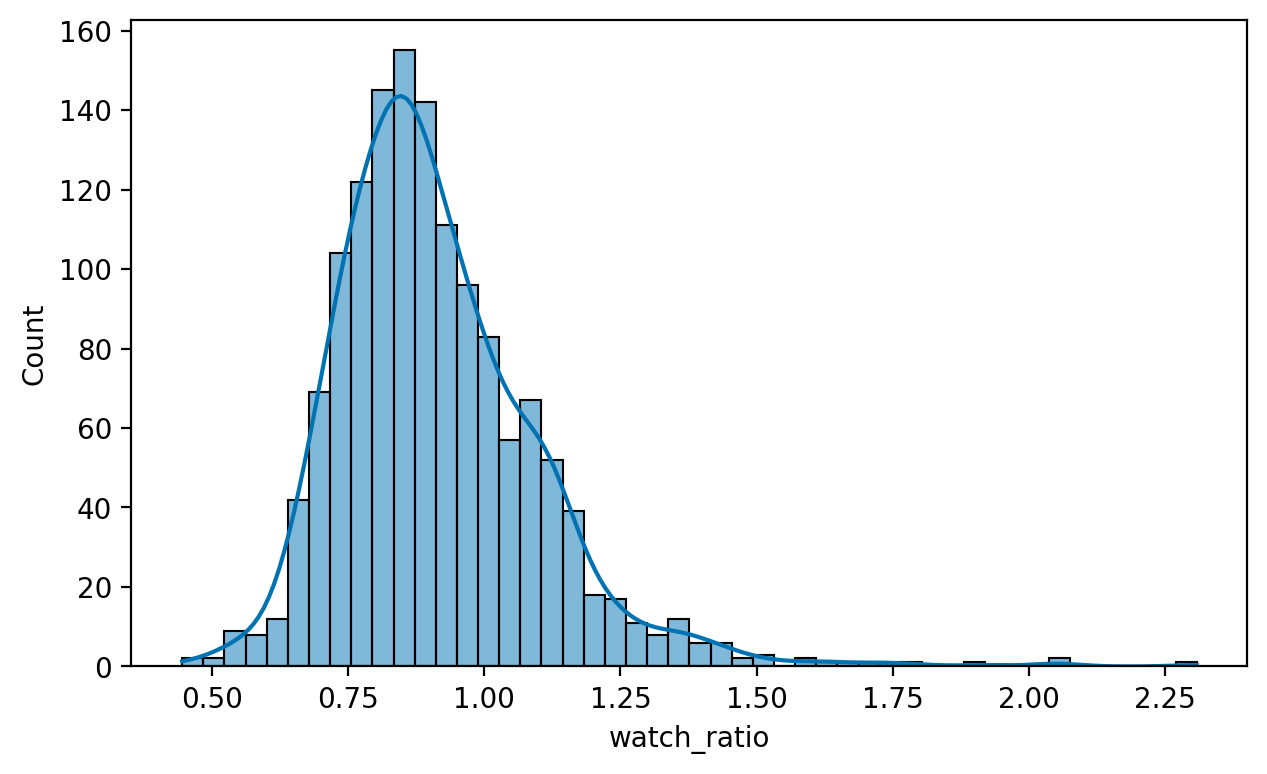

In [13]:
sns.histplot(small_matrix.groupby("user_id")["watch_ratio"].mean(), kde=True)

<Axes: xlabel='watch_ratio', ylabel='Count'>

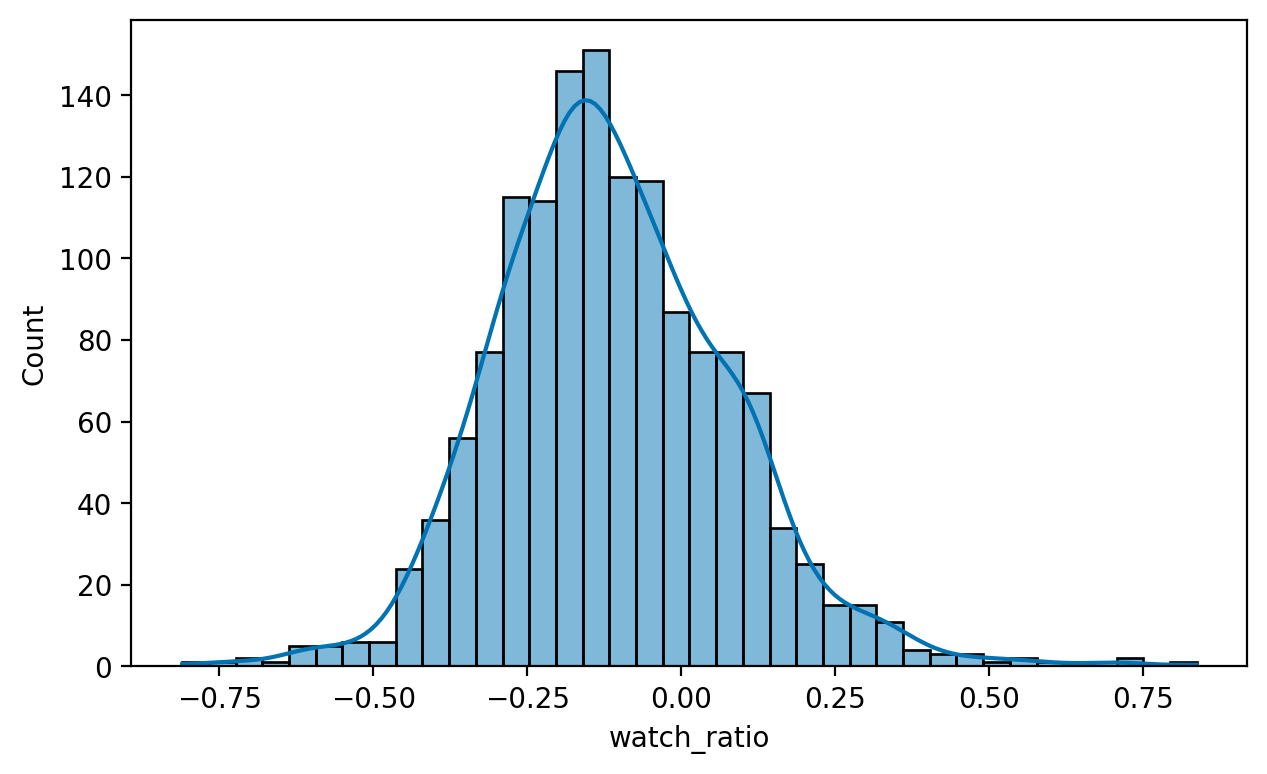

In [14]:
sns.histplot(np.log(small_matrix.groupby("user_id")["watch_ratio"].mean()), kde=True)

## Parse dataset

In [15]:
%%time
small_matrix_sub = small_matrix.dropna(subset="date")
small_matrix_sub = small_matrix_sub.assign(time=pd.to_datetime(small_matrix_sub["time"]))

unique_videos = small_matrix_sub["video_id"].unique()

# Encode new id for Embedding layer
id_to_ix_video = {id.item(): i for i, id in enumerate(unique_videos)}
small_matrix_sub = small_matrix_sub.assign(video_id=small_matrix_sub["video_id"].apply(lambda x: id_to_ix_video[x]))

CPU times: user 3.14 s, sys: 468 ms, total: 3.61 s
Wall time: 3.61 s


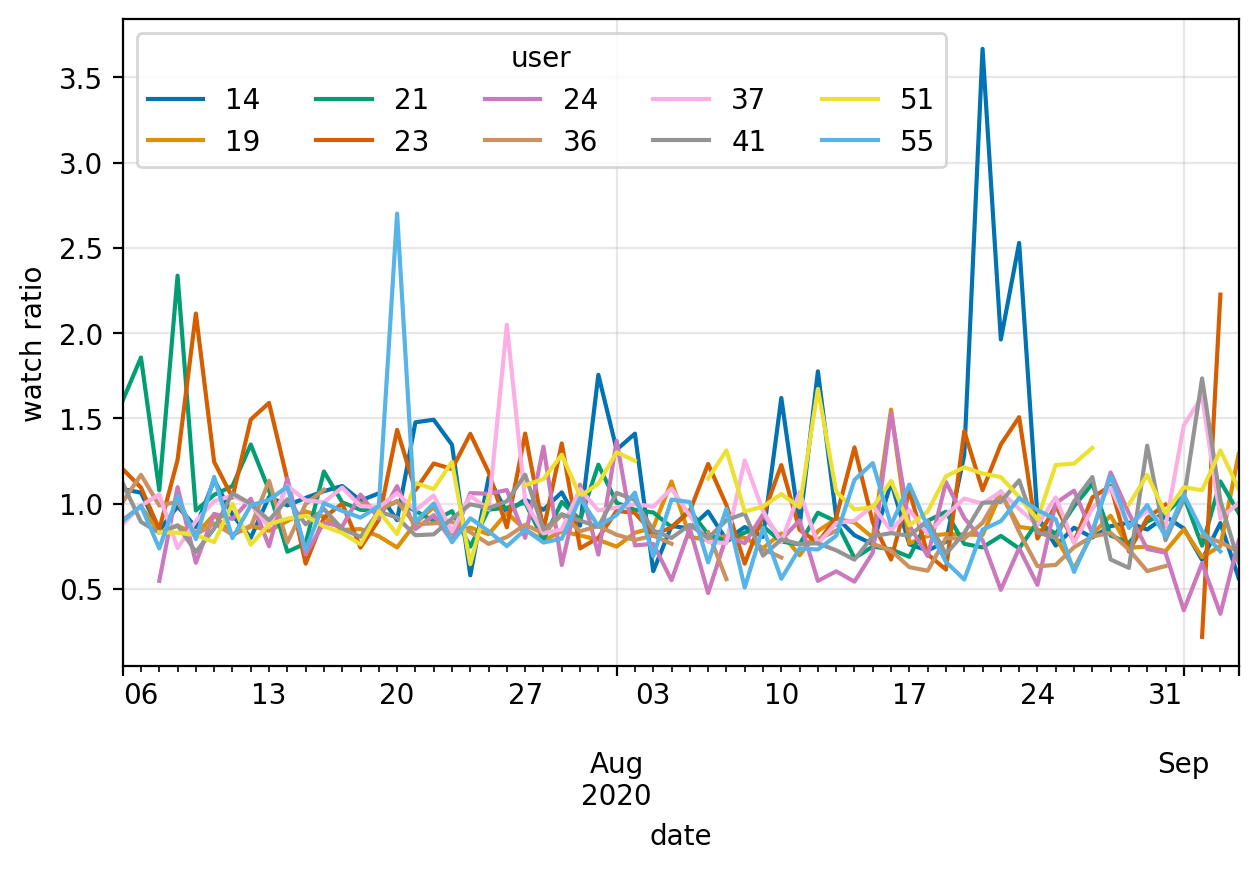

In [16]:
daily_wr = small_matrix_sub.set_index("time").resample("D")["watch_ratio"].mean()

daily_wr = small_matrix_sub.pivot_table(index="date", columns="user_id", values="watch_ratio")
daily_wr.index = pd.to_datetime(daily_wr.index.astype(int).astype(str), yearfirst=format("%Y%m%d"))

daily_wr.iloc[:, :10].plot()
plt.legend(ncol=5, title="user")
plt.ylabel("watch ratio")
plt.grid(alpha=0.3)

## Process dataset

In [38]:
import os
from functools import partial
from multiprocessing import Pool

In [17]:
def parse_batch_users(users, n_arms=5):
    df_batch = []
    for user in users:
        subset = small_matrix_sub.query("user_id == @user")
        n_values = len(subset)
        subset = subset.assign(group=np.arange(n_values) // n_arms)
        
        df_flat = subset.groupby("group").apply(lambda x: x.values.flatten(), include_groups=False).apply(pd.Series)
        df_flat.columns = [f"{col}_{i}" for i in range(n_arms) for col in subset.columns[:-1]]
        df_batch.append(df_flat)
    return df_batch

In [18]:
n_arms = 5
n_cores = os.cpu_count()
users = small_matrix_sub["user_id"].unique()
users_by_batch = np.array_split(users, n_cores)

In [19]:
%%time
poolfn = partial(parse_batch_users, n_arms=n_arms)
with Pool(n_cores) as pool:
    df_all = pool.map(poolfn, users_by_batch)
df_all = [element for batch in df_all for element in batch]
df_all = pd.concat(df_all, axis=0)
df_all.shape

CPU times: user 2.72 s, sys: 8.92 s, total: 11.6 s
Wall time: 15.7 s


(898878, 80)

In [20]:
df_all.head()

,user_id_0,video_id_0,play_duration_0,video_duration_0,time_0,date_0,timestamp_0,watch_ratio_0,like_cnt_0,share_cnt_0,...,timestamp_4,watch_ratio_4,like_cnt_4,share_cnt_4,play_cnt_4,comment_cnt_4,complete_play_cnt_4,follow_cnt_4,reply_comment_cnt_4,download_cnt_4
group,,,,,,,,,,,,,,,,,,,,,
0,14,0,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,3485,72,...,1.593899e+09,0.418364,6404.0,23.0,475632.0,339.0,262597.0,416.0,53.0,14.0
1,14,5,8607,13267,2020-07-05 05:36:00.773,20200705.0,1.593899e+09,0.648753,1463,4,...,1.593900e+09,1.632739,1859.0,8.0,319541.0,10.0,219421.0,198.0,0.0,11.0
2,14,10,8614,6334,2020-07-05 06:14:51.500,20200705.0,1.593901e+09,1.359962,710,2,...,1.593903e+09,1.424427,450.0,85.0,150952.0,26.0,75770.0,42.0,9.0,15.0
3,14,15,8710,7074,2020-07-05 06:52:26.169,20200705.0,1.593903e+09,1.231269,90,2,...,1.593908e+09,1.489885,1902.0,23.0,157182.0,101.0,102681.0,109.0,28.0,11.0
4,14,20,4588,6933,2020-07-05 08:22:10.226,20200705.0,1.593909e+09,0.661763,25537,333,...,1.593911e+09,0.650073,21.0,1.0,3972.0,1.0,2240.0,1.0,0.0,0.0


In [21]:
df_all.to_pickle(f"./data/arms_{n_arms:02}_raw.pkl")

# A simple bandit

In [125]:
import jax
import chex
import flax.linen as nn
import jax.numpy as jnp

In [169]:
n_arms = 10
size_experiment = 200_000

In [126]:
df_all = pd.read_pickle(f"./data/arms_{n_arms:02}_raw.pkl").dropna()
df_all = df_all.sort_values("time_0")
df_all = df_all.sample(frac=1.0, random_state=31, replace=False)

In [127]:
df_all.head()

,user_id_0,video_id_0,play_duration_0,video_duration_0,time_0,date_0,timestamp_0,watch_ratio_0,like_cnt_0,share_cnt_0,...,timestamp_9,watch_ratio_9,like_cnt_9,share_cnt_9,play_cnt_9,comment_cnt_9,complete_play_cnt_9,follow_cnt_9,reply_comment_cnt_9,download_cnt_9
group,,,,,,,,,,,,,,,,,,,,,
311,4300,3196,12227,11332,2020-08-30 12:04:27.409,20200830.0,1.598760e+09,1.078980,38185,594,...,1.598833e+09,1.880121,81261.0,1949.0,3645376.0,1726.0,2468974.0,4009.0,307.0,626.0
58,3411,138,3224,8900,2020-07-16 01:22:07.598,20200716.0,1.594834e+09,0.362247,27,1,...,1.594835e+09,0.285114,7963.0,56.0,470048.0,829.0,299774.0,311.0,157.0,16.0
78,1693,802,9776,6549,2020-07-20 06:06:41.938,20200720.0,1.595196e+09,1.492747,1645,27,...,1.595199e+09,1.077878,228.0,0.0,21147.0,3.0,7481.0,15.0,3.0,1.0
15,3565,496,10499,5984,2020-07-10 06:34:19.259,20200710.0,1.594334e+09,1.754512,15620,381,...,1.594339e+09,1.814921,11240.0,26.0,867629.0,301.0,675127.0,461.0,26.0,24.0
301,1109,3108,4049,24426,2020-08-28 11:46:57.063,20200828.0,1.598586e+09,0.165766,151841,1672,...,1.598593e+09,1.524373,13469.0,2484.0,237055.0,1539.0,79631.0,1179.0,191.0,1250.0


In [153]:
@chex.dataclass
class Bandit:
    pulls: jax.Array
    values: jax.Array
    eps: float
    alpha: float

    def update(self, arm, reward):
        current_value = self.values[arm]
        current_pulls = self.pulls[arm]

        value_update = self.alpha * reward + (1 - self.alpha) * current_value
        
        values_update = self.values.at[arm].set(value_update)
        pulls_update = self.pulls.at[arm].set(current_pulls + 1)

        return self.replace(
            pulls=pulls_update,
            values=values_update
        )

    
    def pick(self, key, x):
        key_arm, key_eps = jax.random.split(key)
        greedy_choice = self.values[x].argmax()

        is_random = jax.random.bernoulli(key_arm, self.eps)
        random_choice = jax.random.choice(key_eps, len(x)).astype(int)

        arm_choice = greedy_choice * (1 - is_random) + random_choice * is_random
        return arm_choice
        
    
    @classmethod
    def init(cls, n_arms, eps, alpha):
        key = jax.random.PRNGKey(1314)
        # TODO: change for zeros
        values = jnp.zeros(n_arms)
        return Bandit(
            pulls=jnp.zeros(n_arms),
            values=values,
            eps=eps,
            alpha=alpha
        )

In [154]:
class ENV:
    def __init__(self):
        ...

    def pull_and_update(self, key, bel, y, x):
        ixmax = bel.pick(key, x)
        reward = y[ixmax]

        bel = bel.update(x[ixmax], reward)
        return bel, reward

    def scan(self, key, bel, Y, X):
        keys = jax.random.split(key, len(X))
        def _step(bel, xs):
            key, y, x = xs
            bel, reward = self.pull_and_update(key, bel, y, x)
            return bel, reward

        XS = (keys, Y, X)
        bel, rewards = jax.lax.scan(_step, bel, XS)
        return bel, rewards

In [155]:
jnp.set_printoptions(suppress=True, precision=3, linewidth=200)

In [156]:
# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]
X.head()

,video_id_0,video_id_1,video_id_2,video_id_3,video_id_4,video_id_5,video_id_6,video_id_7,video_id_8,video_id_9
group,,,,,,,,,,
311,3196,3181.0,3097.0,3168.0,3204.0,3176.0,3177.0,3180.0,3197.0,3185.0
58,138,220.0,473.0,153.0,22.0,114.0,280.0,557.0,867.0,848.0
78,802,953.0,1144.0,777.0,2017.0,811.0,387.0,3318.0,923.0,1684.0
15,496,28.0,9.0,891.0,175.0,277.0,1285.0,19.0,193.0,447.0
301,3108,2248.0,3261.0,2615.0,2483.0,2496.0,3134.0,2468.0,3111.0,2842.0


In [157]:
X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)
n_obs

448552

In [158]:
n_videos = len(small_matrix_sub["video_id"].unique())
bandit_map = Bandit(pulls=0, values=0, eps=None, alpha=None)

### Random bandit

In [159]:
key = jax.random.PRNGKey(314)
env = ENV()

In [135]:
%%time
bandit = Bandit.init(n_arms=n_videos, eps=1.0, alpha=0.3)
bel_random, rewards_random = env.scan(key, bandit, Y[:size_experiment], X[:size_experiment].astype(int))
rewards_random = np.array(rewards_random)

CPU times: user 875 ms, sys: 10.7 ms, total: 886 ms
Wall time: 11 s


### Epsilon bandit

In [136]:
%%time
bandit = Bandit.init(n_arms=n_videos, eps=0.001, alpha=0.3)
bel_eps, rewards_eps = env.scan(key, bandit, Y[:size_experiment], X[:size_experiment].astype(int))
rewards_eps = np.array(rewards_eps)

CPU times: user 808 ms, sys: 28.7 ms, total: 837 ms
Wall time: 10.9 s


## Eval

In [137]:
rewards = pd.DataFrame({
    # "oracle": Y[:size_experiment].max(axis=1),
    "eps": rewards_eps,
    "random": rewards_random
})

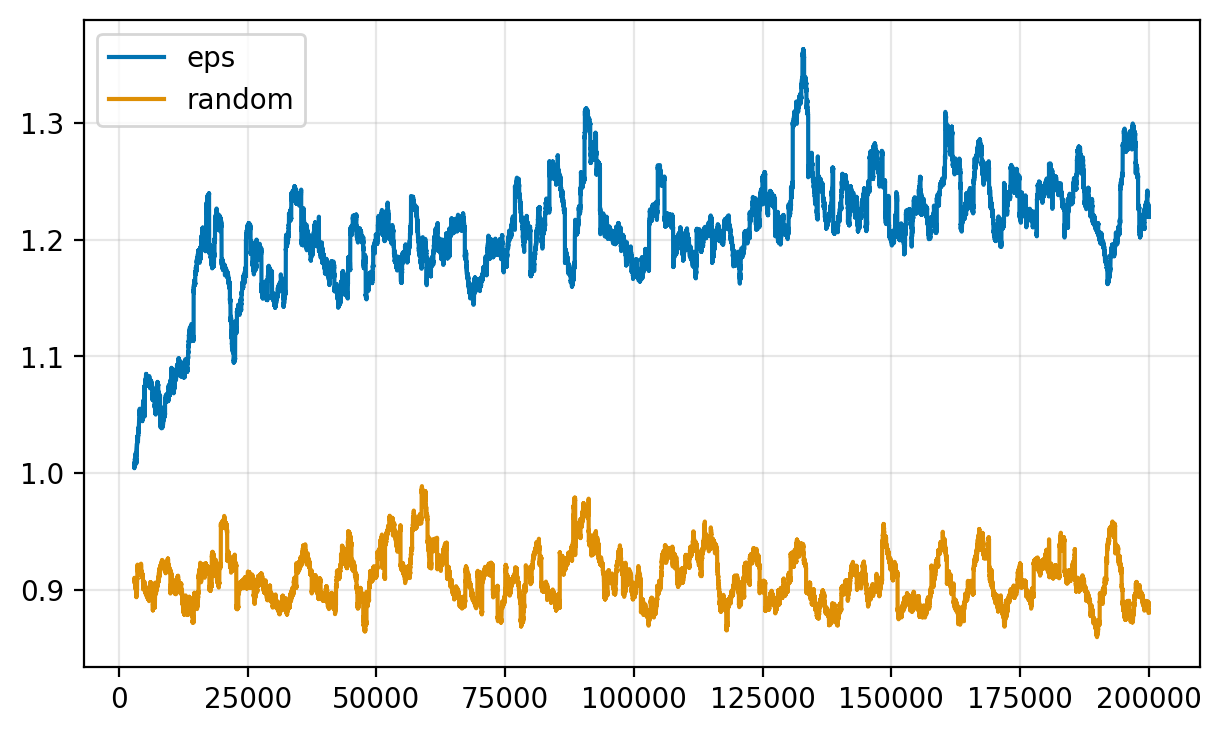

In [138]:
rewards.rolling(window=3_000).mean().plot()
plt.grid(alpha=0.3)

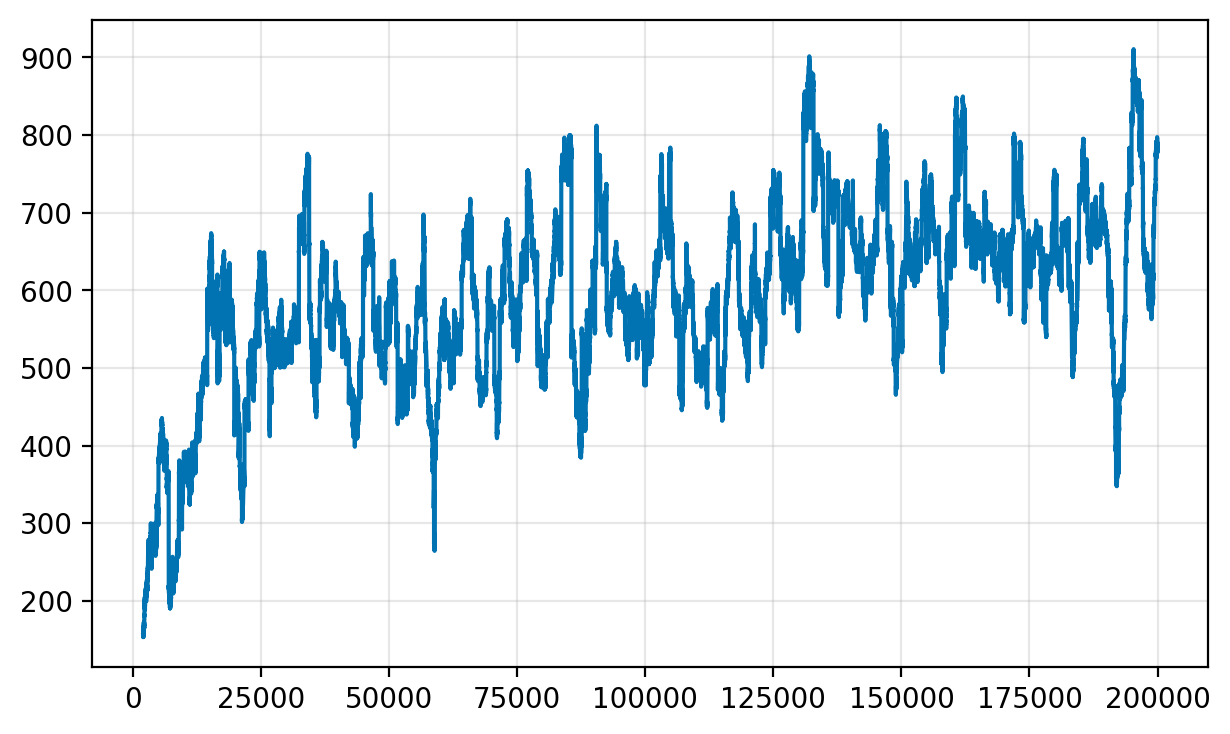

In [142]:
(rewards["eps"] - rewards["random"]).rolling(2_000).sum().plot()
plt.grid(alpha=0.3)

## An $\epsilon$-greedy MLP

In [161]:
pd.set_option("display.width", 300)

In [162]:
target_cols = [
    "like_cnt", "share_cnt", "play_cnt", "comment_cnt",
    "complete_play_cnt", "follow_cnt", "reply_comment_cnt", "download_cnt",
]

In [163]:
# target_cols = ["like_cnt", "share_cnt", "play_cnt", "play_duration", "comment_cnt"]
def in_target_cols(column):
    return any([target_col in column for target_col in target_cols])

# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c) or in_target_cols(c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]

X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)

n_features = len(target_cols) + 1 # video id and like_cnt
X = X.reshape(-1, n_arms, n_features)

X = X.at[..., 1:].set(jnp.log1p(X[..., 1:]))

n_videos = len(small_matrix_sub["video_id"].unique())
bandit_map = Bandit(pulls=0, values=0, eps=None, alpha=None)

In [164]:
class FeatureExtractor(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x_embedding = nn.Embed(self.n_videos, self.embedding_dim)(x[..., 0].astype(int))
        x_features = nn.Dense(self.dense_dim)(x[..., 1:])
        x = jnp.concat([x_embedding, x_features], axis=-1)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x


class MLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = nn.Dense(1, name="last_layer")(x) # reward
        return x

## Run experiment

In [165]:
import optax
from time import time
from functools import partial
from vbll_fifo import FifoLaplaceDiag

In [166]:
from rebayes_mini.methods import low_rank_last_layer as flores
from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_filter as lofi

In [167]:
key = jax.random.PRNGKey(3141)
mlp = MLP(n_videos=n_videos, embedding_dim=10, dense_dim=10, n_hidden=50)
key_init, key_run = jax.random.split(key)
params_init = mlp.init(key_init, X[0, 0])    

In [168]:
def step(state, xs, agent):
    bel, key = state
    yt, xt = xs
    n_arms = xt.shape[0]
    key_sample, key_update = jax.random.split(key, 2)

    bel = agent.predict(bel)

    keys_sample = jax.random.split(key_sample, n_arms)
    rewards_est = jax.vmap(agent.sample_predictive, in_axes=(0, None, 0))(keys_sample, bel, xt)
    
    # Choose the arm to pull
    arm = rewards_est.argmax()
    
    reward_obs = yt[arm]
    x_pulled = xt[arm]

    bel_update = agent.update(bel, reward_obs, x_pulled)
    state_update = (bel_update, key_update)
    return state_update, reward_obs

## Flores

In [170]:
def cov_fn(y): return jnp.eye(1) * 1e-5
agent = flores.LowRankLastLayer(
    mlp.apply, cov_fn, rank=20, dynamics_hidden=0.0, dynamics_last=0.0
)


print("Running agent with Flores")
bel_init = agent.init_bel(params_init, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_flores = jax.lax.scan(_step, state_init, XS)
rewards_flores = np.exp(np.array(rewards_flores)) - 1
time_end = time()

print(rewards_flores.sum())
print(f"Running time {time_end - time_init:.2f}", end=2*"\n")

Running agent with Flores
243178.97
Running time 68.12



## Laplace

In [ ]:
def lossfn(params, counter, x, y, apply_fn, noise=0.1):
    res = apply_fn(params, x).squeeze()
    logprobas = jax.scipy.stats.norm.logpdf(y.squeeze(), res.squeeze(), noise)
    loss = - (logprobas * counter).sum() / counter.sum()
    return loss.squeeze()

learning_rate = 1e-4
buffer_size = 10
n_inner = 50
agent = FifoLaplaceDiag(
    mlp.apply,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=n_inner,
)

bel_init = agent.init_bel(params_init)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_laplace = jax.lax.scan(_step, state_init, XS)
rewards_laplace = np.exp(np.array(rewards_laplace)) - 1
time_end = time()

print(rewards_laplace.sum())
print(f"Running time {time_end - time_init:.2f}", end=2*"\n")

## LRKF

In [174]:
%%time
def cov_fn(y): return jnp.eye(1) * 1e-4
agent = lrkf.LowRankCovarianceFilter(mlp.apply, cov_fn, dynamics_covariance=0.0, rank=50)

bel_init = agent.init_bel(params_init, cov=1.0, low_rank_diag=False)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
(bel_final, _), rewards_lrkf = jax.lax.scan(_step, state_init, XS)
rewards_lrkf = np.exp(np.array(rewards_lrkf)) - 1

CPU times: user 13.3 s, sys: 188 ms, total: 13.5 s
Wall time: 1min 48s


In [175]:
rewards_lrkf.sum()

np.float32(183324.83)

## LoFi

In [72]:
%%time
def cov_fn(y): return jnp.eye(1) * 0.32 ** 2
agent = lofi.LowRankPrecisionFilter(mlp.apply, cov_fn, dynamics_covariance=1e-6, rank=50)

bel_init = agent.init_bel(params_init, cov=0.1)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
# XS = (jnp.log1p(Y[:100]), X[:100])
_step = partial(step, agent=agent)
(bel_final, _), rewards_lofi = jax.lax.scan(_step, state_init, XS)
rewards_lofi = np.exp(np.array(rewards_lofi)) - 1

CPU times: user 13.7 s, sys: 401 ms, total: 14.1 s
Wall time: 10min 57s


## VBLL

In [73]:
import optax
from vbll_fifo import Regression, FifoVBLL, RegressionRefac
from bayesopt import test_functions, eval_fn, agents

In [74]:
class VBLLMLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int
    wishart_scale: float = 0.01
    regularization_weight: float = 1.0


    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=self.wishart_scale,
            regularization_weight=self.regularization_weight,
            name="last_layer",
        )(x)
        return x

learning_rate = 1e-3
buffer_size = 10
n_inner = 10
vbl_mlp = VBLLMLP(
    n_videos=n_videos, embedding_dim=10, n_hidden=50, dense_dim=10, regularization_weight=0.0
)
params_init_vbll = vbl_mlp.init(key_init, X[0,0])

def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

dim = X.shape[-1]

agent = FifoVBLL(
    vbl_mlp.apply,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim,
    dim_output=1,
    n_inner=n_inner,
)

In [75]:
print("Running agent with VBLL")
bel_init = agent.init_bel(params_init_vbll)

time_init = time()
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
(bel_final, _), rewards_vbll_fifo = jax.lax.scan(_step, state_init, XS)
rewards_vbll_fifo = np.exp(np.array(rewards_vbll_fifo)) - 1
time_end = time()

print(rewards_vbll_fifo.sum())
print(f"Running time {time_end - time_init:0.2f}")

Running agent with VBLL
196704.77
Running time 144.55


## Results

In [182]:
index = df_all["time_0"][:size_experiment]
rewards = {
    # "oracle": Y[:50_000].max(axis=1),
    "flores": rewards_flores,
    # "flores_en": rewards_flores_en,
    "vbll": rewards_vbll_fifo,
    # "vbll_flores": rewards_vbll_flores,
    "lrkf": rewards_lrkf,
    "lofi": rewards_lofi,
    # "eps": rewards_eps[:size_experiment],
    "laplace": rewards_laplace,
    "random": rewards_random[:size_experiment],
}
rewards = pd.DataFrame(rewards, index=index)

In [183]:
oracle_reward = pd.Series(Y[:size_experiment].max(axis=1), index=index)

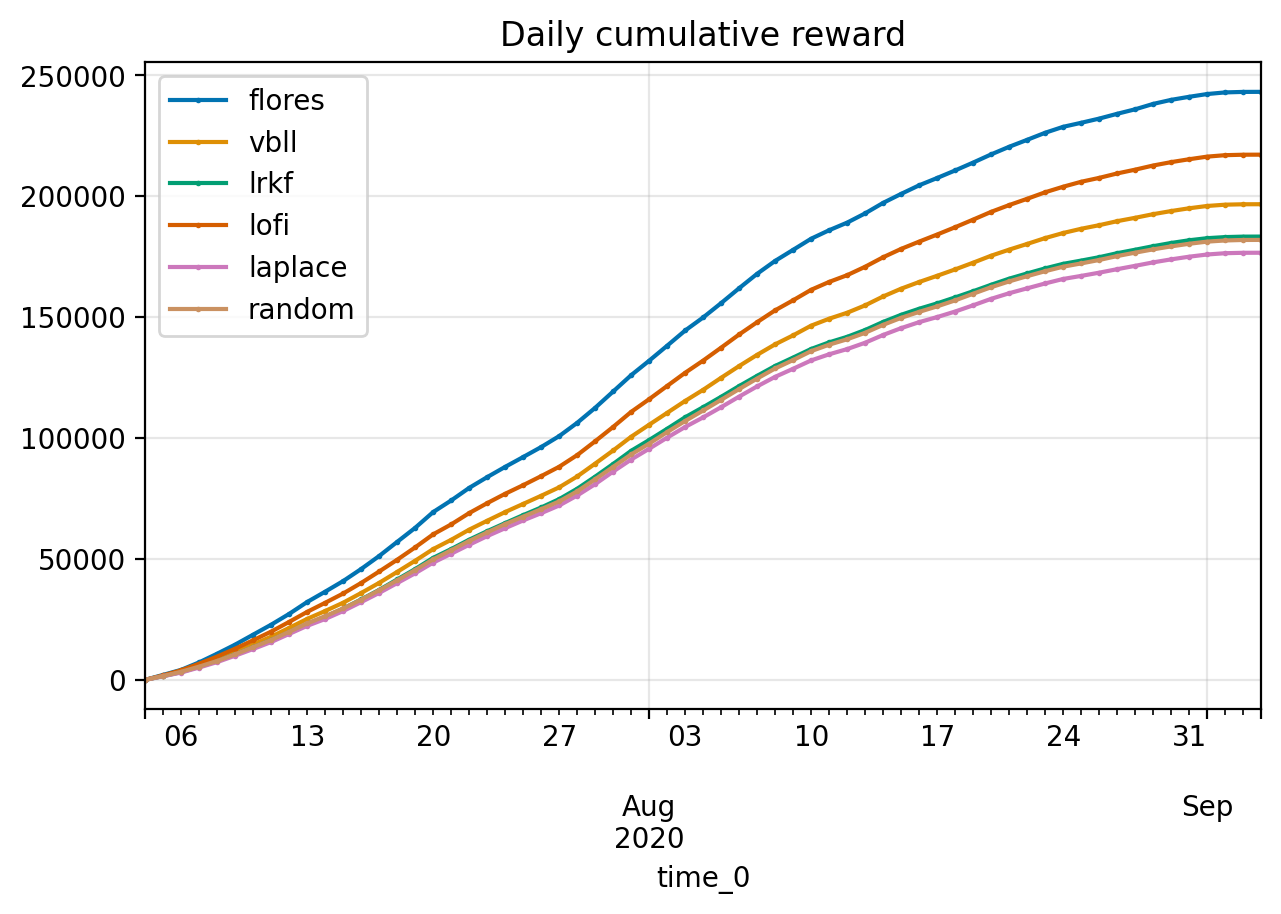

In [184]:
rewards.resample("D").sum().cumsum().plot(marker="o", markersize=1)
plt.title("Daily cumulative reward")
plt.grid(alpha=0.3)

<Axes: xlabel='time_0'>

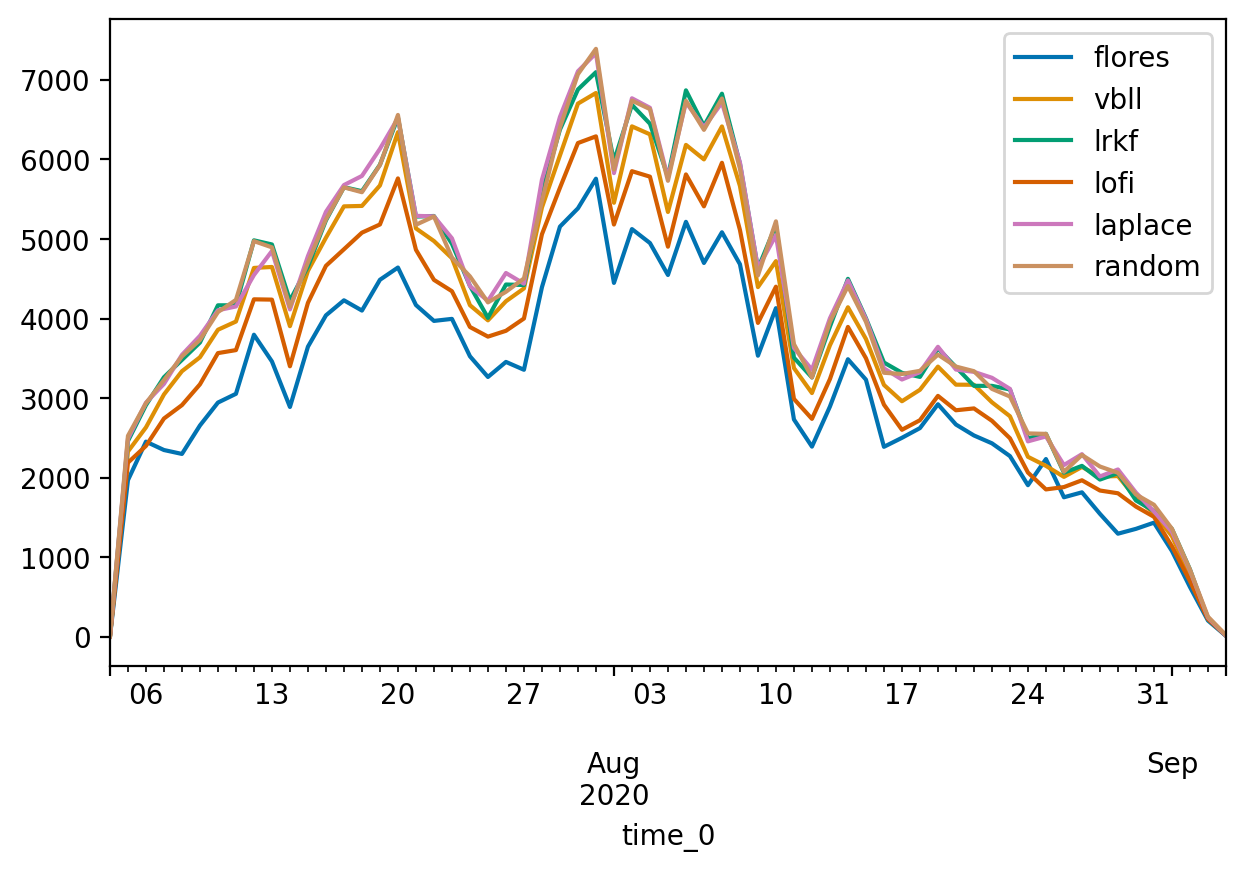

In [104]:
regret = -rewards.resample("D").sum().sub(oracle_reward.resample("D").sum(), axis=0)
regret.plot()

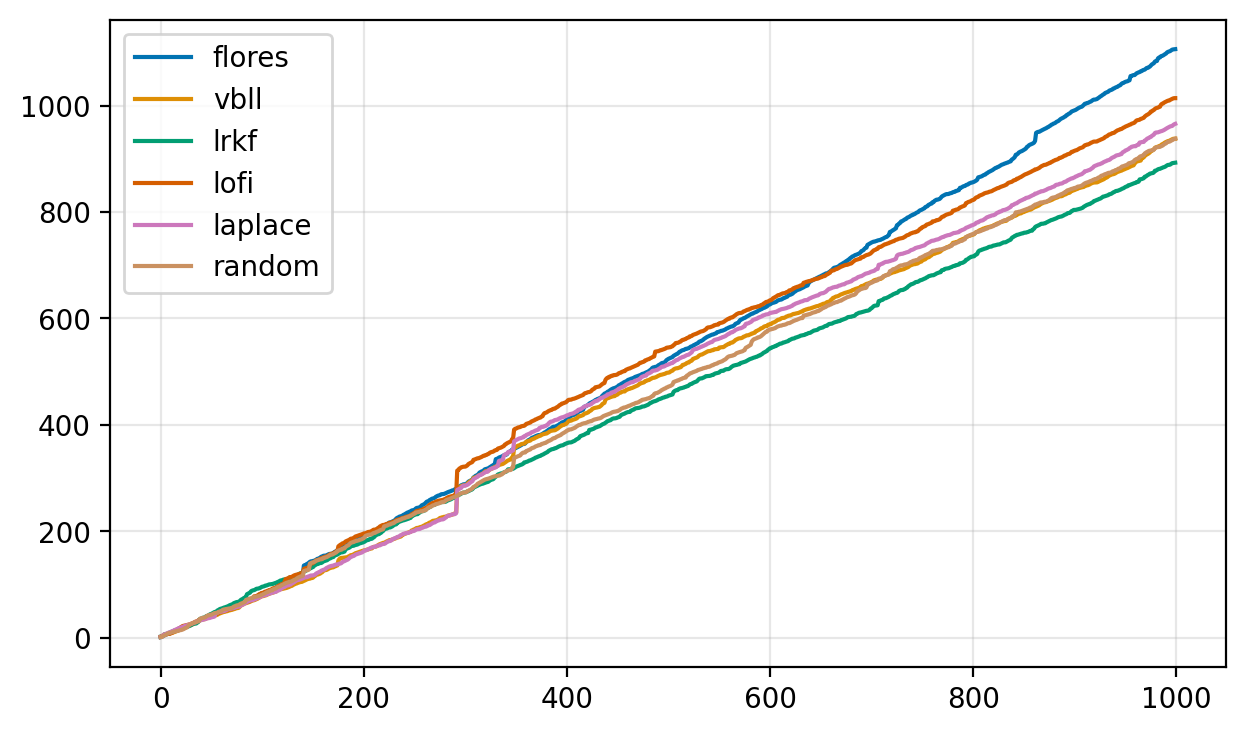

In [114]:
rewards.reset_index(drop=True).cumsum()[:1000].plot()
plt.grid(alpha=0.3)

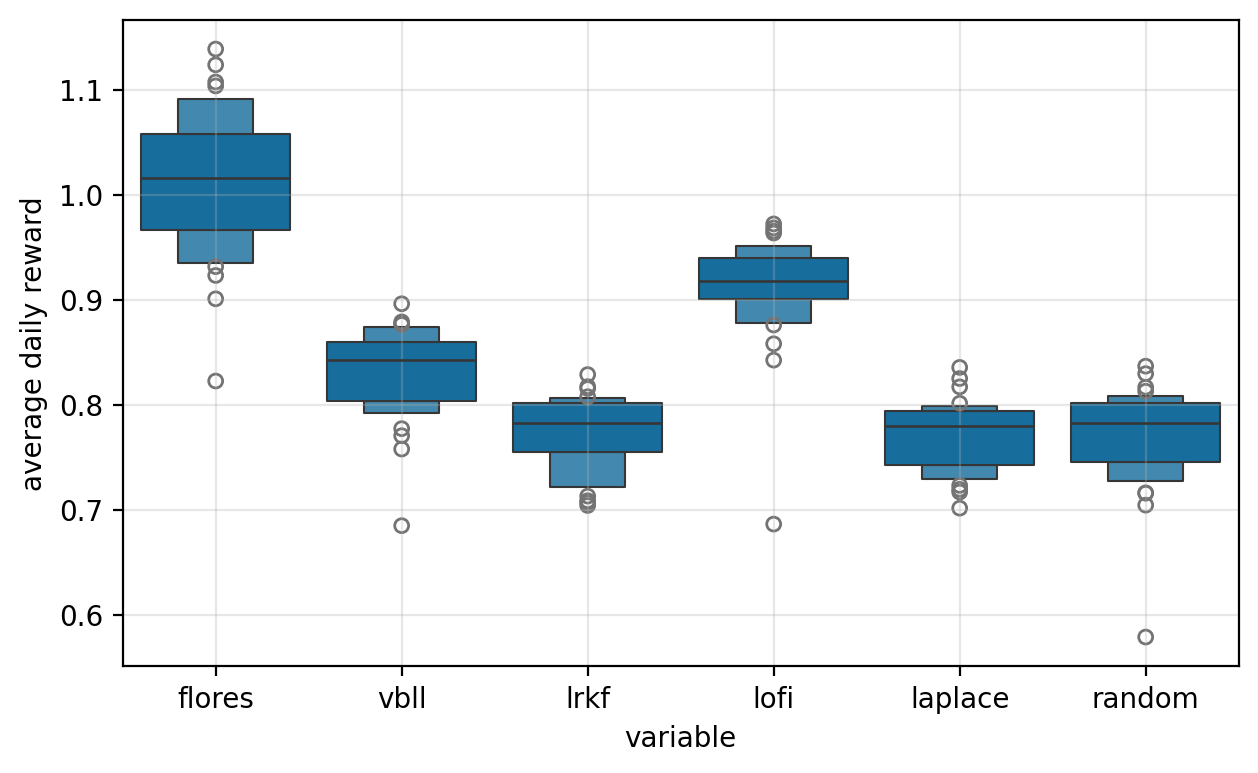

In [115]:
sns.boxenplot(
    x="variable",
    y="value",
    data=rewards.resample("2D").median().melt()
)
plt.ylabel("average daily reward")
plt.grid(alpha=0.3)

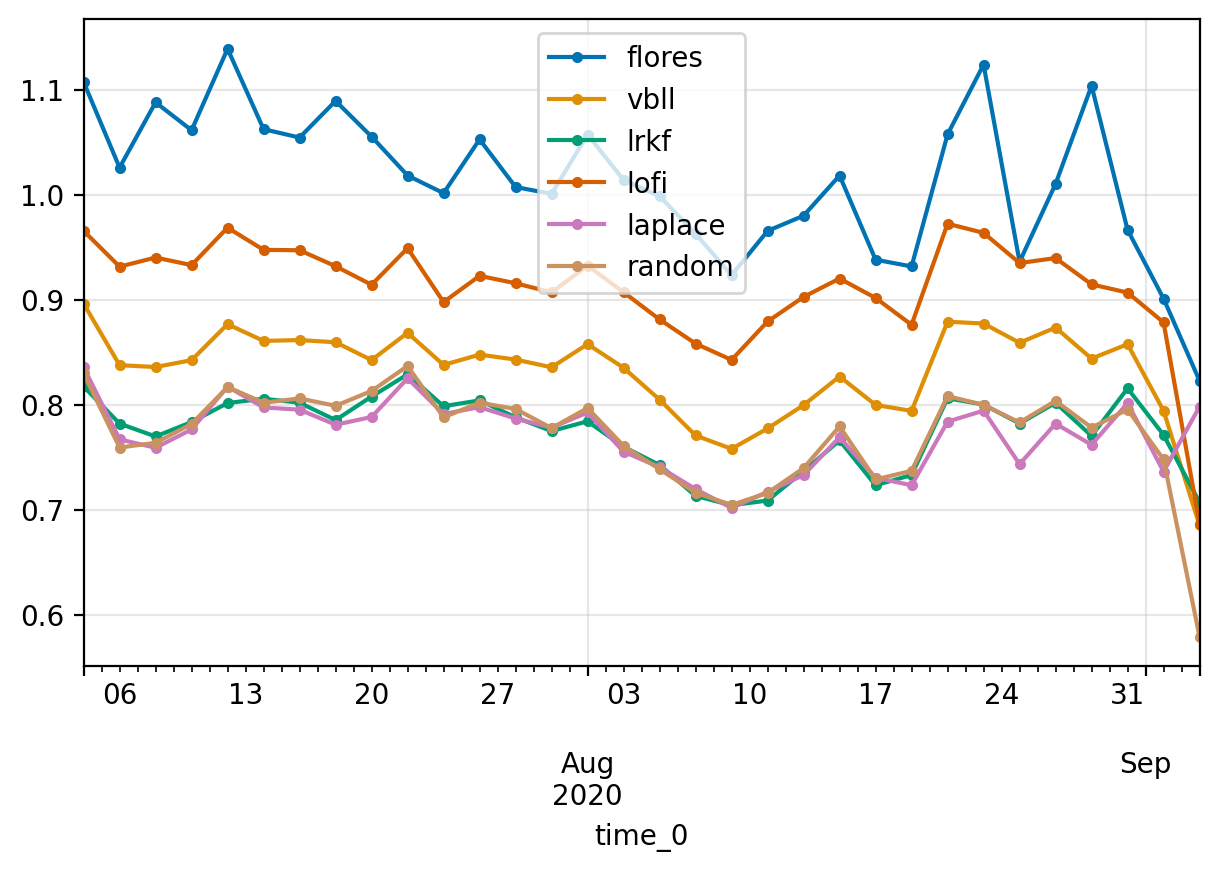

In [117]:
rewards.resample("2D").median().plot(marker="o", markersize=3)
plt.grid(alpha=0.3)